In [1]:
#import statements
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import scipy as scipy
from sklearn.linear_model import LinearRegression
import math

%matplotlib inline

In [2]:
#freshmen is a DataFrame that holds admissions data for the entire UC system from 1994 to 2017 
#Source: https://www.universityofcalifornia.edu/infocenter/admissions-residency-and-ethnicity
freshmen = pd.read_csv("../data/freshmen.csv")
freshmen.head()

,Calculation1,Campus,City,County/State/ Territory,Fall Term,School,Sch Src FR,Uad Uc Ethn 6 Cat,adm (SUM),app (SUM),enr (SUM)
0,F BRAVO MEDICAL MAGNET HS51719,Riverside,Los Angeles,Los Angeles,2008,F BRAVO MEDICAL MAGNET HS,California Public High School,Hispanic/ Latino,39.0,50,10.0
1,ARAGON HIGH SCHOOL53163,Santa Barbara,San Mateo,San Mateo,2012,ARAGON HIGH SCHOOL,California Public High School,Asian,28.0,53,4.0
2,ETIWANDA HIGH SCHOOL50888,San Diego,Etiwanda,San Bernardino,2012,ETIWANDA HIGH SCHOOL,California Public High School,Asian,11.0,34,4.0
3,UPLAND HIGH SCHOOL53586,Merced,Upland,San Bernardino,2005,UPLAND HIGH SCHOOL,California Public High School,Asian,6.0,7,NaN
4,MORNINGSIDE HIGH SCHOOL51262,Los Angeles,Inglewood,Los Angeles,2006,MORNINGSIDE HIGH SCHOOL,California Public High School,All,5.0,22,NaN


In [3]:
#a function that selects rows from data frame df that have values for the columns col_names in the list col_vals
def df_filter(df, col_names, col_vals_list):
    assert len(col_names) == len(col_vals_list), "lists must be same size:"+str(len(col_names))+", "+str(len(col_vals_list))
    
    new_df = df.iloc[:]
    for i in range(len(col_names)):
        col_name, col_vals = col_names[i], col_vals_list[i]
        new_df = new_df.iloc[:][new_df[col_name].isin(col_vals)]
    return new_df

mv_2016_app = df_filter(freshmen, ['School', 'Fall Term'], [['MONTA VISTA HIGH SCHOOL'], [2016]])
mv_2016_app_print = mv_2016_app.loc[:, ['Campus', 'Uad Uc Ethn 6 Cat', 'app (SUM)', 'adm (SUM)', 'enr (SUM)']]

print(mv_2016_app_print)

                Campus Uad Uc Ethn 6 Cat  app (SUM)  adm (SUM)  enr (SUM)
64706   Universitywide  Hispanic/ Latino          6        4.0        NaN
93513           Merced             White          6        5.0        NaN
93769        San Diego   Inter- national          7        NaN        NaN
94803        San Diego             Asian        309      117.0       15.0
109106           Davis               All        376      147.0       20.0
111725          Merced             Asian         69       64.0        NaN
139522        Berkeley   Inter- national          7        NaN        NaN
155727      Santa Cruz             White         31       26.0        8.0
158216        Berkeley             White         27        NaN        NaN
173233          Merced               All         81       75.0        NaN
181082      Santa Cruz               All        291      244.0       37.0
238904       Riverside             Asian        121      104.0        NaN
252997          Irvine             Whi

In [4]:
freshmen_2016 = df_filter(freshmen, ['Fall Term'],[[2016, '2016']]) 
freshmen_2016.describe()
#key takeaways:
    #38,968 students applied to the UCs in 2016 
    #an average of almost 27 students applied to the UCs per school

,Fall Term,adm (SUM),app (SUM),enr (SUM)
count,38968.0,30290.000000,38968.000000,13210.000000
mean,2016.0,14.993265,26.922962,9.934141
std,0.0,21.524602,35.094114,14.083204
min,2016.0,3.000000,5.000000,3.000000
25%,2016.0,5.000000,8.000000,4.000000
50%,2016.0,8.000000,15.000000,5.000000
75%,2016.0,16.000000,31.000000,10.000000
max,2016.0,419.000000,515.000000,259.000000


In [5]:
#import database regarding wealth distributions from different counties in 2016
#Source: https://datausa.io/profile/geo/california/#economy
county_wealth = pd.read_csv("../data/CA County Wealth Data.csv")
#create a copy of the 2016 database that removes the discrepancies between county names and removes the "geo" column
county_wealth = county_wealth.iloc[:, [0, 1, 3]]
for i in range(len(county_wealth)):
    index = county_wealth.iloc[i, 1].find("County") 
    if (index != -1):
        county_wealth.iloc[i, 1] = county_wealth.iloc[i, 1][:index].strip()
    else:
        county_wealth.iloc[i, 1] = county_wealth.iloc[i, 1][:].strip()

county_wealth.head()

,year,geo_name,income
0,2013,Alameda,72112.0
1,2013,Alpine,58636.0
2,2013,Amador,53684.0
3,2013,Butte,43752.0
4,2013,Calaveras,55295.0


In [6]:
def income_dict_gen(county_wealth, year_in):
    #create a copy of the wealth database with only data from the year year_in
    def county_wealth_in_year(df):
        return df.iloc[:][df['year'].isin([year_in])] 
    #create a copy of the wealth database with only data from year_in and excluding the 'geo' column
    county_year = county_wealth_in_year(county_wealth)
    
    #transform this into a dictionary formatted like this:
    #   {county: income}
    county_income_dict = {}
    for i in range(len(county_year)):
        county_income_dict[county_year.iloc[i, 1]] = county_year.iloc[i, 2]
    return county_income_dict

county_income_dict = income_dict_gen(county_wealth, 2016)
#print(county_income_dict)

In [7]:
def print_admissions_numbers(df):
    for i in range(len(df)):
        school = df.iloc[i]
        if (not(math.isnan(school["enr (SUM)"]))):
            print("{school:35s} -> applied:{applied:4.0f}  /  admitted:{admitted:3.0f}  /  enrolled:{enrollees:3.0f}".format(
                school = school["School"], 
                applied = school["app (SUM)"],
                admitted = school["adm (SUM)"],
                enrollees = school["enr (SUM)"]
            ))
            
#print_admissions_numbers(berk_acceptance_2016_schools_list)

In [8]:
#ca_pu_2016_berk is a dataframe that holds acceptance numbers for schools that have students who enrolled in the 
# 2016 fall term to berkeley. 

#Column 0 -> County/State/Territory   -> County of Origin for the high school
#Column 1 -> School                   -> School Name
#Column 2 -> adm (SUM)                -> number of students from the school admitted
#Column 3 -> app (SUM)                -> number of students from the school who applied
#Column 4 -> enr (SUM)                -> number of students from the school who enrolled

#filter Year to 2016, School Type to CA Public, Campus to UCB, exclude schools with no enrolled students, and have only ^ columns 
ca_pub_2016_berk = df_filter(freshmen, ['Fall Term', 'Sch Src FR', 'Campus'], [[2016], ['California Public High School'], ['Berkeley']]).iloc[:, [3, 5, 8, 9, 10]][freshmen['enr (SUM)'] > 0]

print_admissions_numbers(ca_pub_2016_berk)

C:\Users\aurum\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


CLEVELAND HIGH SCHOOL               -> applied:  26  /  admitted: 11  /  enrolled:  9
JAMES LOGAN HIGH SCHOOL             -> applied: 155  /  admitted: 22  /  enrolled: 14
ARLINGTON HIGH SCHOOL               -> applied:  33  /  admitted:  5  /  enrolled:  4
APTOS HIGH SCHOOL                   -> applied:  36  /  admitted: 10  /  enrolled:  4
BENICIA HIGH SCHOOL                 -> applied:  12  /  admitted:  3  /  enrolled:  3
CHINO HILLS HIGH SCHOOL             -> applied:  35  /  admitted: 11  /  enrolled:  4
ANALY HIGH SCHOOL                   -> applied:  34  /  admitted: 10  /  enrolled:  9
STEM ACADEMY OF HOLLYWOOD           -> applied:  21  /  admitted:  4  /  enrolled:  3
ARAGON HIGH SCHOOL                  -> applied:  57  /  admitted: 17  /  enrolled: 10
LOS OSOS HIGH SCHOOL                -> applied:  97  /  admitted:  9  /  enrolled:  5
SEGERSTROM HIGH SCHOOL              -> applied:  31  /  admitted:  4  /  enrolled:  3
WEST RANCH HIGH SCHOOL              -> applied:  44  /

C K MCCLATCHY HIGH SCHOOL           -> applied:  24  /  admitted:  7  /  enrolled:  4
HIGH TECH HIGH MEDIA ARTS           -> applied:  20  /  admitted:  3  /  enrolled:  3
BEVERLY HILLS HIGH SCHOOL           -> applied:  64  /  admitted: 14  /  enrolled:  7
WEST HIGH SCHOOL                    -> applied:  93  /  admitted: 15  /  enrolled:  5
NEWBURY PARK HIGH SCHOOL            -> applied:  30  /  admitted: 11  /  enrolled:  5
CHULA VISTA LRNG CMNTY CHARTER      -> applied:  14  /  admitted:  3  /  enrolled:  3
MERRILL F WEST HIGH SCHOOL          -> applied:  29  /  admitted:  8  /  enrolled:  8
EL DIAMANTE HIGH SCHOOL             -> applied:  22  /  admitted:  7  /  enrolled:  3
LOS ALAMITOS HIGH SCHOOL            -> applied:  38  /  admitted:  8  /  enrolled:  3
CARMEL HIGH SCHOOL                  -> applied:  31  /  admitted:  8  /  enrolled:  3
BONITA HIGH SCHOOL                  -> applied:  44  /  admitted: 12  /  enrolled:  9
POINT LOMA HIGH SCHOOL              -> applied:  38  /

OAKLAND TECHNICAL HIGH SCHOOL       -> applied:  18  /  admitted:  5  /  enrolled:  3
DEL NORTE HIGH SCHOOL               -> applied:  26  /  admitted:  7  /  enrolled:  3
SEGERSTROM HIGH SCHOOL              -> applied:  46  /  admitted:  8  /  enrolled:  5
JAMES LOGAN HIGH SCHOOL             -> applied: 100  /  admitted: 17  /  enrolled: 12
PITTSBURG HIGH SCHOOL               -> applied:  60  /  admitted:  8  /  enrolled:  5
DIAMOND BAR HIGH SCHOOL             -> applied: 238  /  admitted: 67  /  enrolled: 37
DIAMOND BAR HIGH SCHOOL             -> applied: 198  /  admitted: 61  /  enrolled: 33
HIGH TECH HIGH-NORTH COUNTY         -> applied:  19  /  admitted:  5  /  enrolled:  4
DIAMOND RANCH HIGH SCHOOL           -> applied:  35  /  admitted: 10  /  enrolled:  7
DIAMOND RANCH HIGH SCHOOL           -> applied:  13  /  admitted:  5  /  enrolled:  5
DOS PUEBLOS HIGH SCHOOL             -> applied:  27  /  admitted:  8  /  enrolled:  6
DOUGHERTY VALLEY HIGH SCHOOL        -> applied: 228  /

OXNARD HIGH SCHOOL                  -> applied:  21  /  admitted:  4  /  enrolled:  3
PACIFIC COLLEGIATE SCHOOL           -> applied:  30  /  admitted:  7  /  enrolled:  3
PACIFICA HIGH SCHOOL                -> applied:  25  /  admitted:  5  /  enrolled:  4
PALISADES CHARTER HIGH SCHOOL       -> applied: 148  /  admitted: 41  /  enrolled: 29
PALISADES CHARTER HIGH SCHOOL       -> applied:  81  /  admitted: 23  /  enrolled: 18
PALM DESERT HIGH SCHOOL             -> applied:  36  /  admitted:  9  /  enrolled:  6
PALM DESERT HIGH SCHOOL             -> applied:  17  /  admitted:  5  /  enrolled:  3
PALO ALTO SENIOR HIGH SCHOOL        -> applied:  64  /  admitted: 14  /  enrolled:  8
RAMON C CORTINES SCH VIS PERF       -> applied:  41  /  admitted: 11  /  enrolled:  4
WOODBRIDGE HIGH SCHOOL              -> applied:  69  /  admitted: 22  /  enrolled: 13
PALOS VERDES HIGH SCHOOL            -> applied:  54  /  admitted: 16  /  enrolled:  5
PALOS VERDES PENINSULA HS           -> applied:  49  /

In [9]:
#Create a DataFrame that takes in the counts of application, admittance, and enrollment for all schools in a given county,
# and then concatenates data from the wealth data of the county to draw socioeconomic conclusions about admissions rate

#format for dictionary county_dict => {'County': [Applied, Admitted, Enrolled, Income]}

def income_vs_admit_df_gen(df):
    county_dict = {}
    for i in range(len(df)):
        county = df.iloc[i]
        county_name = county[0]
        #create the entry in the dict for a county if it doesn't already exist
        if (county_name not in county_dict):
            county_dict[county_name] = [0, 0, 0, county_income_dict[county_name]/10000]
        #update the entry for the county with the school's data
        num_applied, num_admitted, num_enrolled = df.iloc[i][3], df.iloc[i][2], df.iloc[i][4]
        county_num_applied, county_num_admitted, county_num_enrolled = county_dict[county_name][0], county_dict[county_name][1], county_dict[county_name][2]
        county_dict[county_name][0] = county_num_applied  + num_applied
        county_dict[county_name][1] = county_num_admitted + num_admitted
        county_dict[county_name][2] = county_num_enrolled + num_enrolled    
    return pd.DataFrame(data=county_dict)
      
county_admissions_and_income = income_vs_admit_df_gen(ca_pub_2016_berk)
print(county_admissions_and_income)

   Los Angeles    Alameda  Riverside  Santa Cruz    Solano  San Bernardino  \
0    9875.0000  4455.0000   788.0000    116.0000  197.0000        552.0000   
1    2516.0000  1063.0000   164.0000     29.0000   35.0000        113.0000   
2    1367.0000   704.0000    90.0000     13.0000   22.0000         72.0000   
3       5.7952     7.9831     5.7972      7.0088    6.9227          5.4469   

     Sonoma  San Mateo     Orange  Santa Clara   ...       Kings      Yolo  \
0  153.0000  1346.0000  5159.0000    5591.0000   ...     19.0000  350.0000   
1   37.0000   313.0000  1265.0000    1428.0000   ...      7.0000   67.0000   
2   27.0000   177.0000   643.0000     835.0000   ...      6.0000   42.0000   
3    6.6833     9.8546     7.8145      10.1173   ...      4.7241    5.7663   

   Stanislaus     Napa  Shasta     Lake   Nevada  San Benito   Madera   Sutter  
0    162.0000  52.0000  8.0000  15.0000  21.0000     28.0000  11.0000  19.0000  
1     43.0000  12.0000  4.0000   7.0000   7.0000      4.

In [10]:
def print_regression(xdat, ydat, label):
    #print introduction
    print ("Regression Equations For:", label)
    #calculate regression variables
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=xdat, y=ydat)
    #print regression equation
    print("Linear Regression Equation:", str(round(slope, 2)) + 'x + ' + str(round(intercept, 2)),
          "\nr^2:", str(round(pow(r_value, 2), 4)), "p-value:", str(round(p_value, 4)))

In [11]:
def plot_wealth_vs_data(ydata, label, log=False, percentage=False, robust_in=False, title_addition=""):
    sns.regplot(county_wealth_array, ydata[0], label=label[0], ci=None, scatter=True, truncate=True, robust=robust_in)
    sns.regplot(county_wealth_array, ydata[1], label=label[1], ci=None, scatter=True, truncate=True, robust=robust_in)
    sns.regplot(county_wealth_array, ydata[2], label=label[2], ci=None, scatter=True, truncate=True, robust=robust_in)
    #title, scale, and ylabel decision-making
    if log:
        plt.yscale('log')
        plt.xscale('log')
        titl = 'Log-Scaled'
    else:
        titl = 'Natural Scale'
        
    if percentage:
        titl = titl + ' Percentage'
        plt.ylabel('Percentage of Students')
    else:
        titl = titl + ' Raw Numbers'
        plt.ylabel('Number of Students')
    
    titl = titl + title_addition 
    #show the graph
    plt.title(titl)
    plt.xlabel('Median Household Income of County (in $10,000)')
    plt.legend()
    plt.show()
    #print slope information
    print_regression(county_wealth_array, ydata[0], label[0])
    print_regression(county_wealth_array, ydata[1], label[1])
    print_regression(county_wealth_array, ydata[2], label[2])
    print("\n")

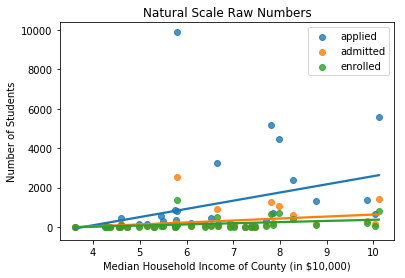

Regression Equations For: applied
Linear Regression Equation: 415.16x + -1573.03 
r^2: 0.1185 p-value: 0.0343
Regression Equations For: admitted
Linear Regression Equation: 99.84x + -369.6 
r^2: 0.106 p-value: 0.046
Regression Equations For: enrolled
Linear Regression Equation: 58.63x + -220.89 
r^2: 0.1166 p-value: 0.0359




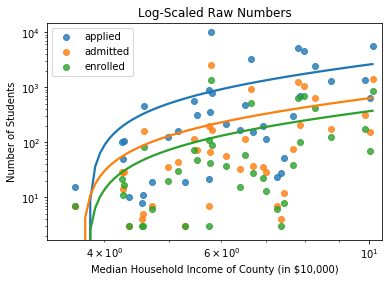

Regression Equations For: applied
Linear Regression Equation: 415.16x + -1573.03 
r^2: 0.1185 p-value: 0.0343
Regression Equations For: admitted
Linear Regression Equation: 99.84x + -369.6 
r^2: 0.106 p-value: 0.046
Regression Equations For: enrolled
Linear Regression Equation: 58.63x + -220.89 
r^2: 0.1166 p-value: 0.0359




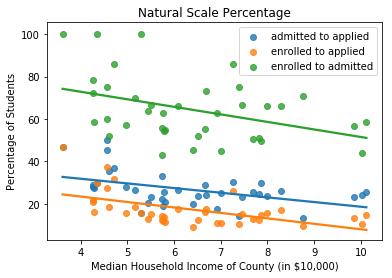

Regression Equations For: admitted to applied
Linear Regression Equation: -2.2x + 40.62 
r^2: 0.2176 p-value: 0.0032
Regression Equations For: enrolled to applied
Linear Regression Equation: -2.57x + 33.73 
r^2: 0.297 p-value: 0.0004
Regression Equations For: enrolled to admitted
Linear Regression Equation: -3.55x + 87.04 
r^2: 0.1598 p-value: 0.0129




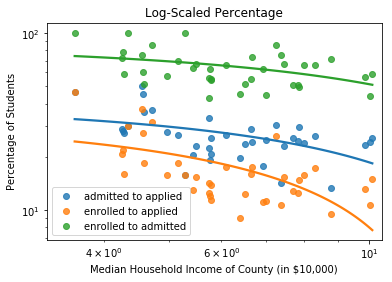

Regression Equations For: admitted to applied
Linear Regression Equation: -2.2x + 40.62 
r^2: 0.2176 p-value: 0.0032
Regression Equations For: enrolled to applied
Linear Regression Equation: -2.57x + 33.73 
r^2: 0.297 p-value: 0.0004
Regression Equations For: enrolled to admitted
Linear Regression Equation: -3.55x + 87.04 
r^2: 0.1598 p-value: 0.0129




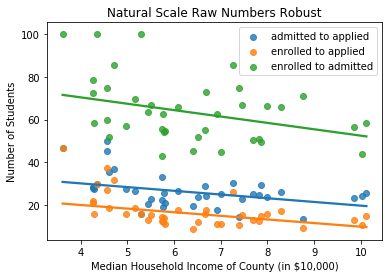

Regression Equations For: admitted to applied
Linear Regression Equation: -2.2x + 40.62 
r^2: 0.2176 p-value: 0.0032
Regression Equations For: enrolled to applied
Linear Regression Equation: -2.57x + 33.73 
r^2: 0.297 p-value: 0.0004
Regression Equations For: enrolled to admitted
Linear Regression Equation: -3.55x + 87.04 
r^2: 0.1598 p-value: 0.0129




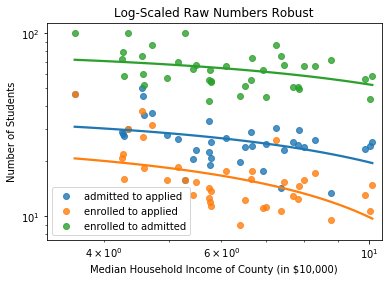

Regression Equations For: admitted to applied
Linear Regression Equation: -2.2x + 40.62 
r^2: 0.2176 p-value: 0.0032
Regression Equations For: enrolled to applied
Linear Regression Equation: -2.57x + 33.73 
r^2: 0.297 p-value: 0.0004
Regression Equations For: enrolled to admitted
Linear Regression Equation: -3.55x + 87.04 
r^2: 0.1598 p-value: 0.0129




In [12]:
def plot_graphs():
    #graph the data generated from the county_admissions_and_income DataFrame using matplotlib
    #convert data to np arrays
    county_name_array = county_admissions_and_income.columns.values
    county_applied_array = county_admissions_and_income.iloc[0].values
    county_admitted_array = county_admissions_and_income.iloc[1].values
    county_enrollment_array = county_admissions_and_income.iloc[2].values
    county_wealth_array = county_admissions_and_income.iloc[3].values


    ###############################################################################################################################
    #############################                            RAW NUMBERS                              #############################
    ###############################################################################################################################

    #list form for data for applied v. wealth, admitted v. wealth, and enrolled v. wealth
    simple_graph_labels = ['applied', 'admitted', 'enrolled']
    simple_graph_ydata = [county_applied_array, county_admitted_array, county_enrollment_array]

    #plot the data as is with a trendline, with regular scaling
    plot_wealth_vs_data(simple_graph_ydata, simple_graph_labels, False, False)

    #plot the data with a trendline, this time with a double-axis log
    plot_wealth_vs_data(simple_graph_ydata, simple_graph_labels, True, False)


    ###############################################################################################################################
    #############################                            PERCENTAGES                              #############################
    ###############################################################################################################################


    admitted_to_applied_percentage = county_admitted_array/county_applied_array*100
    enrolled_to_applied_percentage = county_enrollment_array/county_applied_array*100
    enrolled_to_admitted_percentage = county_enrollment_array/county_admitted_array*100

    #list form for data for admitted to applied v. wealth, enrolled to applied v. wealth, and enrolled to admitted v. wealth
    ratio_graph_labels = ['admitted to applied', 'enrolled to applied', 'enrolled to admitted']
    ratio_graph_ydata = [admitted_to_applied_percentage, enrolled_to_applied_percentage, enrolled_to_admitted_percentage]

    #plot the data as is with a trendline, with regular scaling
    plot_wealth_vs_data(ratio_graph_ydata, ratio_graph_labels, False, True)

    #plot the data with a trendline, this time with a double-axis log
    plot_wealth_vs_data(ratio_graph_ydata, ratio_graph_labels, True, True)


    ###############################################################################################################################
    #############################                        ROBUST PERCENTAGES                           #############################
    ###############################################################################################################################


    #list form for data for admitted to applied v. wealth, enrolled to applied v. wealth, and enrolled to admitted v. wealth
    robust_graph_labels = ['admitted to applied', 'enrolled to applied', 'enrolled to admitted']
    robust_graph_ydata = [admitted_to_applied_percentage, enrolled_to_applied_percentage, enrolled_to_admitted_percentage]

    #plot the data as is with a trendline, with regular scaling
    plot_wealth_vs_data(robust_graph_ydata, robust_graph_labels, False, False, True, " Robust")

    #plot the data with a trendline, this time with a double-axis log
    plot_wealth_vs_data(robust_graph_ydata, robust_graph_labels, True, False, True, " Robust")
